In [1]:
import matplotlib.gridspec as gridspec
import  time; start_time = time.time()
import        matplotlib.pyplot as plt
from              matplotlib import rc
import               matplotlib as mpl
import                importlib as imp
import                    pandas as pd
import                     numpy as np
import                        warnings
import                            dill
import                            pyEW
import                            json
import                              os

mpl.rcParams['axes.linewidth'] = 0.5
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans']})

In [2]:
# time 
t_end = 1*365 # [d]: number of simulated days
dt = 1/(24*6) # [time resolution (d)]
t=np.arange(0,t_end,dt)

#units
conv_mol = 1e6 # Conversion from moles to micromols 
conv_Al = 1e3 # Conversion for Al species from mols to nanomols

#water balance
keyword_wb = 1 # 1 = varying soil moisture. 0 = constant soil moisture

#background inputs of cations and anions
keyword_add = 1 # 1 = balance background losses. 0 = no addition

In [3]:
# HYDROCLIMATE AND WATER BALANCE

#soil 
soil = "loam" #sand, loamy sand, sandy loam, loam, clay loam, clay
Zr = 0.3 # [m]: soil depth
rho_bulk = 1.2*1e6 #soil dry mass (g/m3)
s_in = 0.5

#hydroclimatic
day1 = 1 #initial DOY
latitude = 40*np.pi/180 # [radians]
albedo = 0.25
altitude = 33 #[m]
wind = 1*np.ones(len(t)) #[m/s]
coastal = False 
temp_av = 13 # [°C] yearly average
temp_ampl_yr= 11 # [°C] yearly amplitude
temp_ampl_d= 5 # [°C] daily amplitude

#temp [Celsius]
[temp_air,temp_soil,temp_min,temp_max] = pyEW.temp(latitude,temp_av, temp_ampl_yr, temp_ampl_d, Zr,t_end,dt,day1)

#ET0 [m/d]
ET0 = pyEW.ET0(latitude,altitude,temp_air,temp_soil,temp_min,temp_max, wind,albedo,Zr,coastal,t_end,dt,day1)

In [4]:
#stochastic rain [m]
R_tot = 1.0 # [m/yr]
lamda = 0.1 # [d^(-1)]: average rain frequency 
alfa = (R_tot/lamda)/365 # [m]: average rain depth 
rain = np.load('./Example_SS_Data/rain_1_lamda_p1.npy')

In [6]:
#vegetation [g/m2]
T_v = 100 # [d] growth time
k_v = 3000 # [g/m2] carrying capacity
RAI = 10 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = 1*k_v # [g/m2] ic
t0_v = 0 # [d] starting day of growth
v = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)

#moisture balance (I, Q [m], L, T, E [m/d])
[s, s_w, s_i, I, L, T, E, Q, Irr, n] = pyEW.moisture_balance(rain, Zr, soil, ET0, v, k_v, keyword_wb, s_in,t_end,dt)

# ORGANIC CARBON and RESPIRATION
CO2_atm = pyEW.CO2_atm(conv_mol)

#initial pCO2
CO2_air_in = 10*CO2_atm # CO2 in soil air [mol-conv/l] 
ratio_aut_het = 1

#Initial organic carbon
ADD = 1 # added dry litter [gOC/(m2*d)]
SOC_perc = 0.05 # [%]
SOC_in = rho_bulk*SOC_perc/100 #[gOC/m3] 

#SOC balance and respiration
[SOC, r_het, r_aut, D] = pyEW.respiration(ADD, SOC_in, CO2_air_in, ratio_aut_het, soil, s, v, k_v, Zr, temp_soil,dt,conv_mol)

# SOIL BIOGEOCHEMISTRY

#initial pH
pH_in = 4

#CEC 
CEC_tot = 10 # [mmol_c / 100 g dry-soil] 
CEC_tot = CEC_tot*1e-5*rho_bulk*Zr*conv_mol # [mol_c] 

#CEC fractions
f_Ca_in =  0.3
f_Mg_in = 0.15
f_K_in  =  0.1
f_Na_in = 0.05
f_Al_in =    0
f_H_in  =  0.4

f_CEC_in = np.array([f_Ca_in, f_Mg_in, f_K_in, f_Na_in, f_Al_in, f_H_in]) 
if abs(sum(f_CEC_in)-1) > 1e-3:
    raise ValueError("Sum of fractions must be 1")
    
#carbonates
CaCO3_in = 0
MgCO3_in = 0

#conc water
Si_in = 0 
[conc_in, K_CEC] = pyEW.f_CEC_to_conc(f_CEC_in, pH_in, soil, conv_mol,conv_Al)

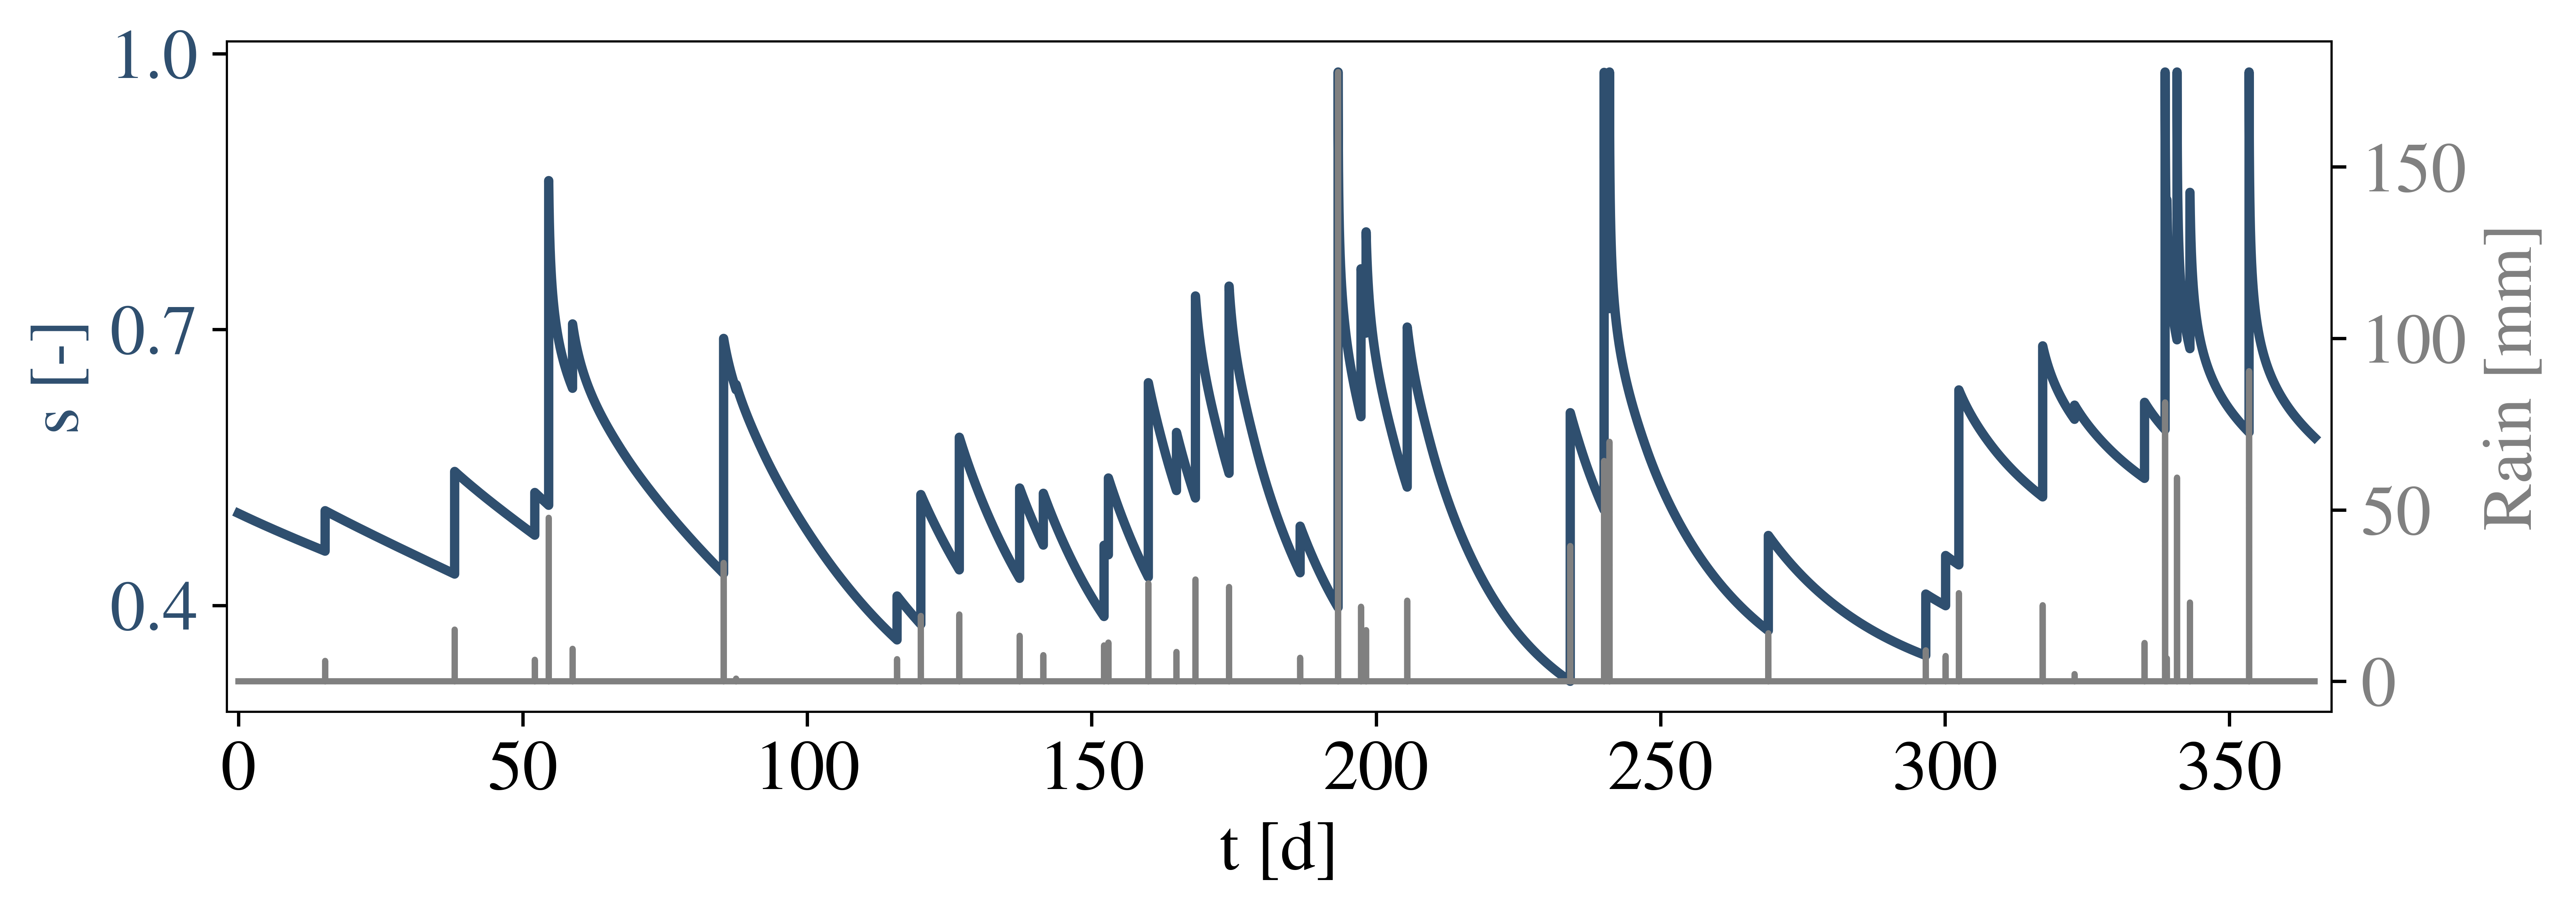

In [8]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

lwg    =         2
fsg    =        17
colr_sm = '#2f4f6f'#'#8c7a5b' #'#e6ac00'

fig = plt.figure(figsize = (8.73, 3.16), dpi = 800)
ax1 = plt.subplot(111)
ax1.set_ylabel('s [-]', color=colr_sm, fontsize = fsg)
ax1.plot(t, s, linewidth=2.25, color=colr_sm, zorder = 2)
ax1.tick_params(axis='y', labelcolor=colr_sm)
plt.xticks(fontsize = fsg)
plt.yticks([0.4, 0.7, 1], fontsize = fsg)

ax1.set_xlabel('t [d]', fontsize = fsg)

ax2 = ax1.twinx()
ax2.set_ylabel('Rain [mm]', color='grey', fontsize = fsg)
ax2.plot(t, rain*1e3, color='grey', zorder =1)  # Note the swapping of x and y data
ax2.tick_params(axis='y', labelcolor='grey')

plt.xticks(fontsize = fsg)
plt.xlim(-2,368)
plt.yticks([0, 50, 100, 150], fontsize = fsg)

plt.tight_layout()
plt.show()

In [9]:
def dis_rock_number_from_mass(mass_distribution_rock, diameter_rock, density_rock):
    return mass_distribution_rock / (density_rock*((np.pi*(diameter_rock)**3)/6))

def dis_rock_mass_from_mass_class(mass_class_rock, diameter_rock, total_mass_rock):
    return (psd_perc_in*total_mass_rock) / np.insert(np.diff(rock_d_meter), 0, rock_d_meter[0])

In [10]:
#EW application

rock_d_meter = np.load('./Example_SS_Data/rock_d_meter.npy')
psd_rock_num = np.load('./Example_SS_Data/psd_rock_num.npy')

mineral = ["forsterite"] 
rock_f_in = np.array([1]) # mineral fractions
diss_f = 1 # dissolution factor
d_in = rock_d_meter # [m]: diameter classes
SSA_in = 3.88 # [m2/g]: either measured value or nan to estimate it
t_app = 0 # day of application

rho_rock_in     =                                                  3*1e6 # [g/m3]
psd_rock_mass_g = psd_rock_num*rho_rock_in*((np.pi*(rock_d_meter)**3)/6)
M_rock_in       = np.trapz(psd_rock_mass_g,                rock_d_meter)  #g

delta_d     = np.insert(np.diff(rock_d_meter), 0, rock_d_meter[0]) #differential
psd_perc_in =                    psd_rock_mass_g*delta_d/M_rock_in

pore_d_in   =  np.load('./Example_SS_Data/pore_d_meter.npy')
pore_pdf_in = np.load('./Example_SS_Data/loampdf_meter.npy')

mixing_alpha = 1

/tmp/ipykernel_636487/1934055200.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M_rock_in       = np.trapz(psd_rock_mass_g,                rock_d_meter)  #g


In [ ]:
data = pyEW.biogeochem_balance_SS(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, t_app, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, pore_d_in, pore_pdf_in, rho_rock_in, mixing_alpha, dt, conv_Al, conv_mol, keyword_add)
    
with open('./Example_SS_Data/data.pkl', 'wb') as f:
    dill.dump(data, f)